<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_StateSpace_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages( "KFAS" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は場合分けをせず、時系列分析します。

# 手順１　データの収集


*　[データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [ ]:
# 該当リポジトリを変数に格納
repo = 
  c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" )

# 人口推計に使うデータの格納場所を変数に格納
popURL = 
  c( "main/data/population_jp_year.csv" )

# ライブラリの読み込み
library( readr )
library( dplyr )

repo |>
  paste0( popURL ) |>                     # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  select( Year,                           # 総人口と出生、死亡のデータ
          Total,
          Birth,
          Death ) |>
  mutate( Year = {
    paste0( Year, "-10-01" ) |>           # １０月１日現在の日付型にする
      as.Date()}
  ) ->
pop_df

# 手順２　データの可視化

まず、データをプロットしてみます。

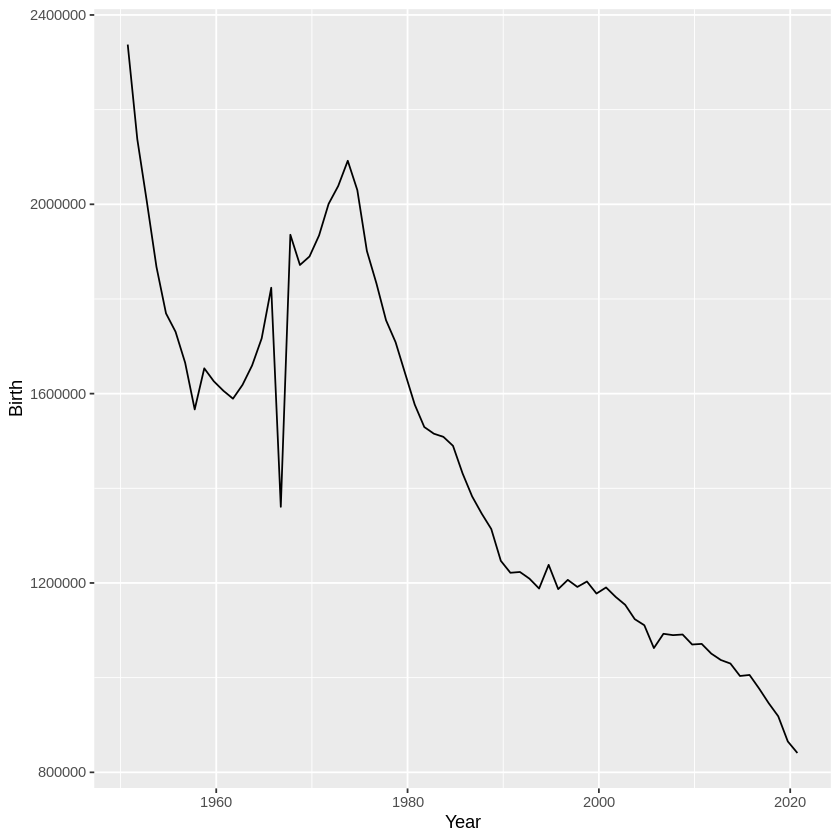

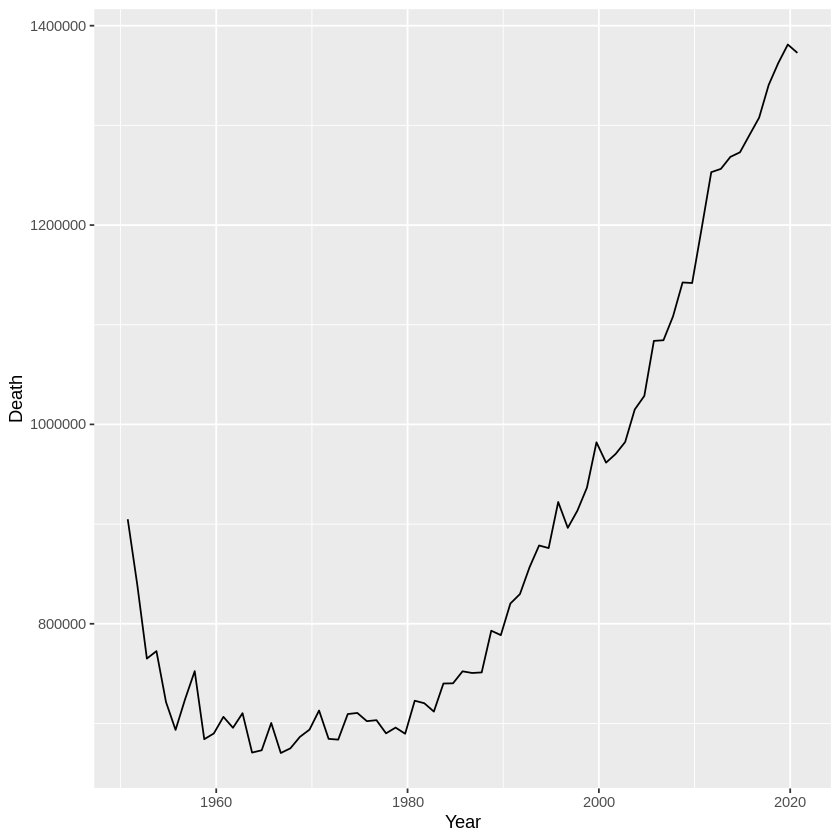

In [ ]:
# ライブラリの読み込み
library( ggplot2 )

# 出生数、死亡数のグラフ
pop_df |>
  ggplot( aes( x = Year,
               y = Birth )) +
  geom_line() 

pop_df |>
  ggplot( aes( x = Year,
               y = Death )) +
  geom_line()

次に、自己相関を確認してみます。

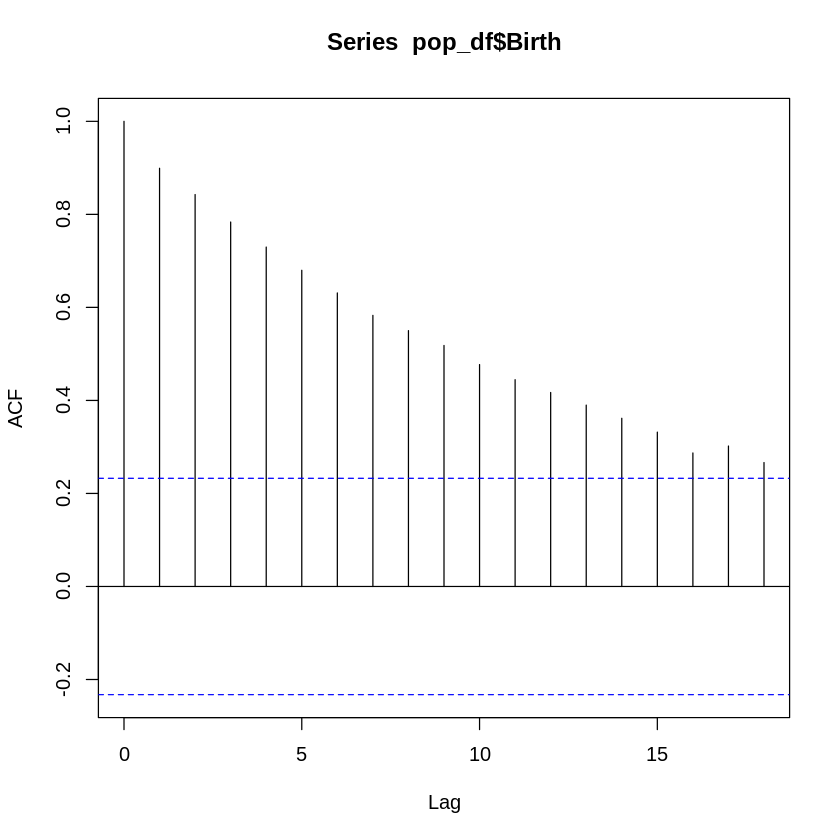

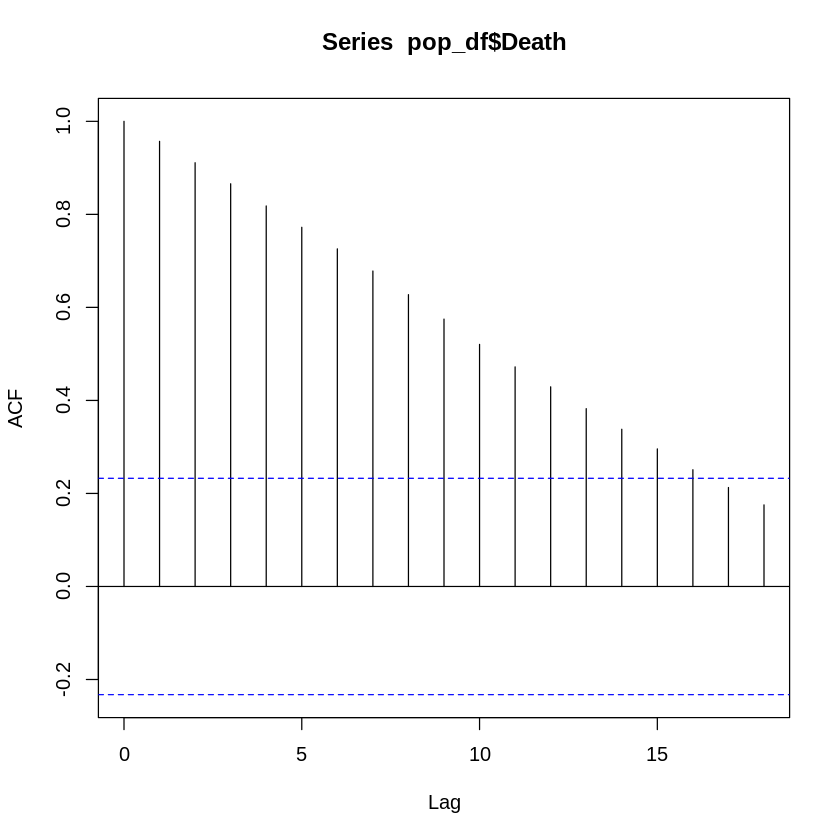

In [ ]:
# 自己相関のグラフ
pop_df$Birth |>
  acf()
pop_df$Death |>
  acf()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

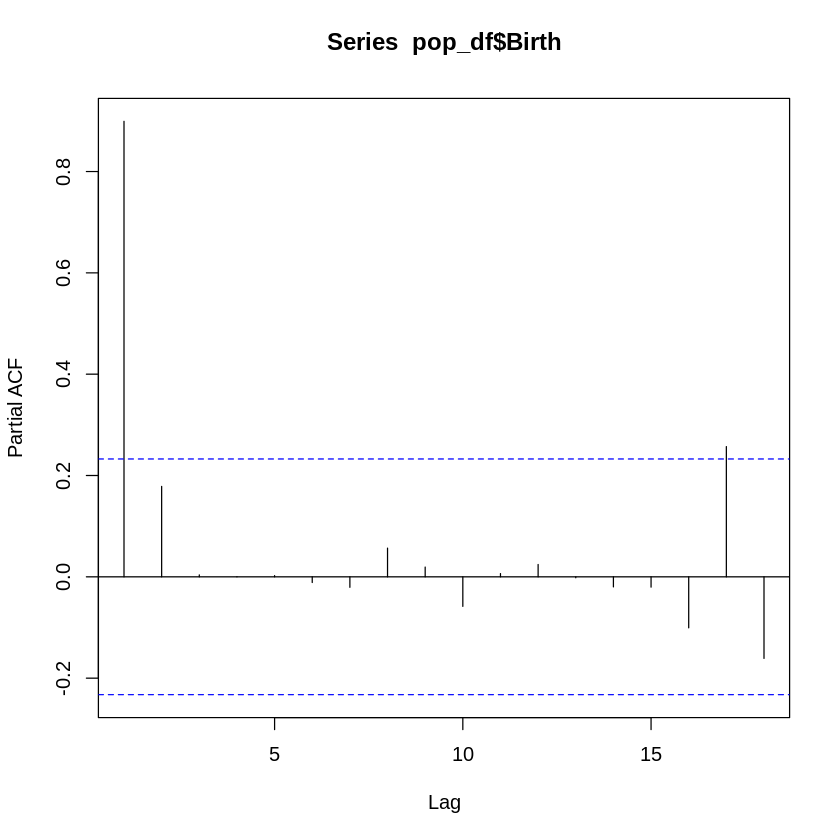

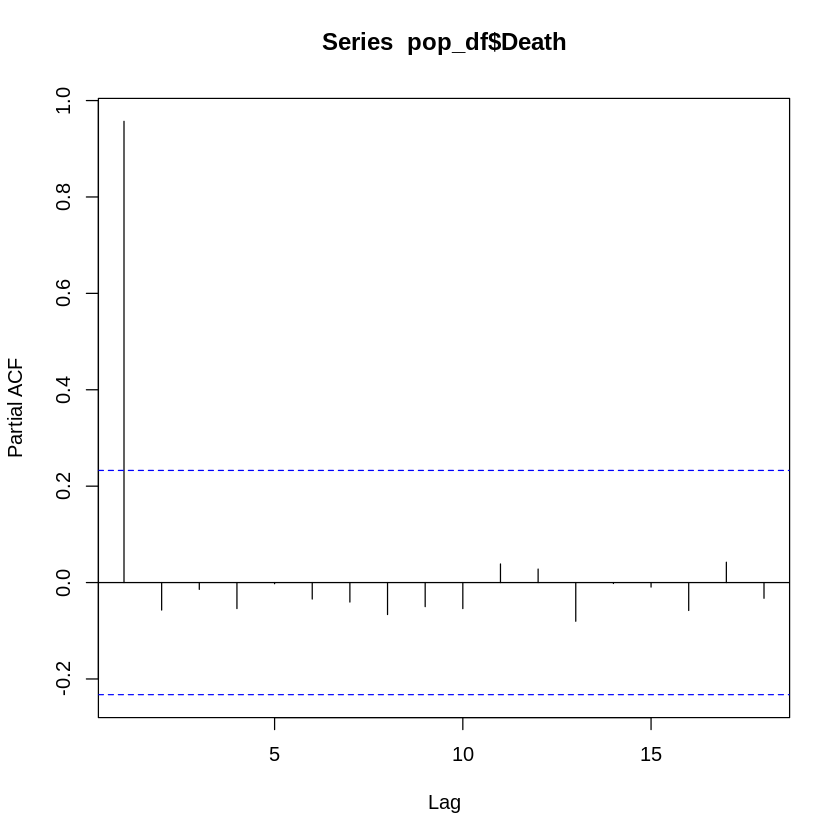

In [ ]:
# 偏自己相関のグラフ
pop_df$Birth |>
  pacf()
pop_df$Death |>
  pacf()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [ ]:
# 学習データと予測データ
prow_test2 = 6
prow_train2 = nrow( pop_df ) - prow_test2

pop_df |>
  tail( n = prow_test2 ) ->
pop_test2

pop_df |>
  head( n = prow_train2 ) ->
pop_train2

# 手順４　状態空間モデルによる予測

ローカル線形トレンドモデルを使用して、予測をしてみます。

In [ ]:
# ライブラリの読み込み
library( KFAS )

# モデル構造の決定
SSModel( H = NA,
         pop_train2$Birth ~ SSMtrend( degree = 2,
                                     Q = list( NA, NA ))) |>
  fitSSM( inits = c( 1, 1, 1 )) ->        # パラメタ推定
fit_trend_B

SSModel( H = NA,
         pop_train2$Death ~ SSMtrend( degree = 2,
                                     Q = list( NA, NA ))) |>
  fitSSM( inits = c( 1, 1, 1 )) ->        # パラメタ推定
fit_trend_D

# 将来予測の結果と予測区間
fit_trend_B$model |>
  predict( interval = "prediction",
           n.ahead = 6 ) |>
  as.data.frame() ->
forecast_trend_B

fit_trend_D$model |>
  predict( interval = "prediction",
           n.ahead = 6 ) |>
  as.data.frame() ->
  forecast_trend_D

# 手順５　出生数、死亡数から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [ ]:
# 出生数、死亡数の合算
pop_test2 |>
  rename( "forecast_BD" = Total ) ->
pop_SS_f2

forecast_trend_B |>
  select( fit ) ->
pop_SS_f2[, 3 ]

forecast_trend_D |>
  select( fit ) ->
pop_SS_f2[, 4 ]

pop_SS_f2 |>
  mutate( forecast_BD = lag( forecast_BD + Birth - Death )) ->
pop_SS_f2
pop_SS_f2

Year,forecast_BD,Birth,Death
<date>,<dbl>,<dbl>,<dbl>
2015-10-01,NA,967546.0,1277919
2016-10-01,126784627,951697.7,1284283
2017-10-01,126600414,935849.4,1290648
2018-10-01,126351201,920001.2,1297013
2019-10-01,126065988,904152.9,1303377
2020-10-01,125767775,888304.6,1309742


# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-10-01,126933000,126784627,126838000,126864000,126912000,126938000
2017-10-01,126706000,126600414,126532000,126605000,126704000,126777000
2018-10-01,126443000,126351201,126177000,126315000,126441000,126580000
2019-10-01,126167000,126065988,125773000,125998000,126125000,126351000
2020-10-01,126146000,125767775,125325000,125658000,125761000,126094000


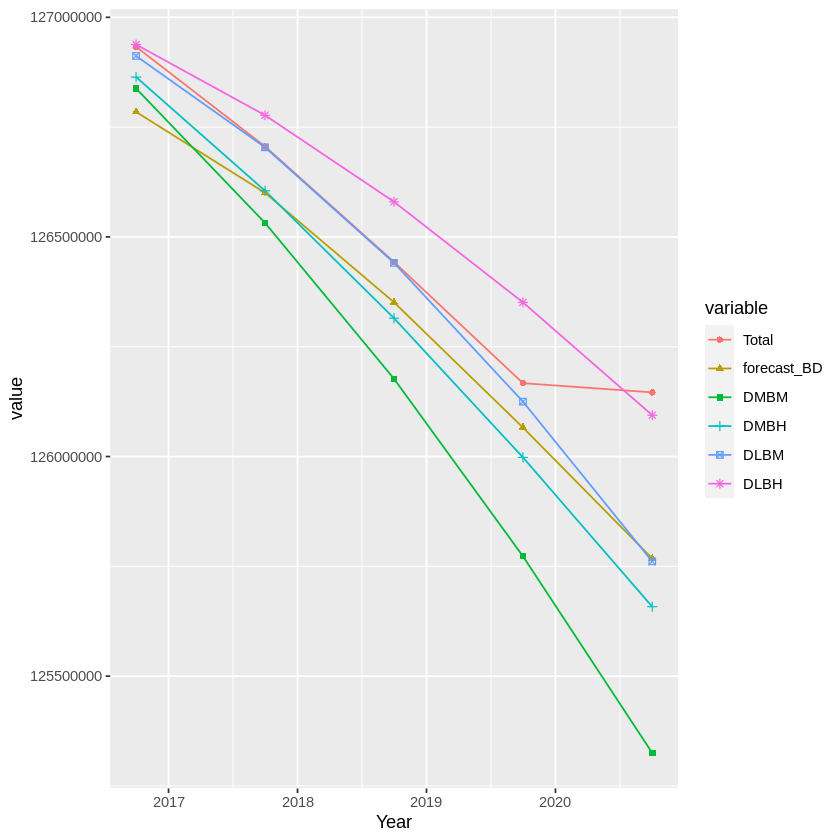

In [ ]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = 
  c( "main/data/forecast_ipss.csv" )

repo |>
  paste0( ipssURL ) |>                    # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  mutate( Year = {
    paste0( Year, "-10-01" ) |>           # １０月１日現在の日付型にする
      as.Date()}
  ) ->
ipss_test

pop_SS_f2[ 2:6, 1:2 ] |>
  inner_join( pop_test2, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) ->
join_test2
join_test2

# ライブラリの読み込み
library( reshape2 )

# 描画
join_test2 |> 
  melt( id = "Year",
        measure = c( "Total",
                     "forecast_BD",
                     "DMBM",
                     "DMBH",
                     "DLBM",
                     "DLBH" )) |>
  ggplot( aes( x = Year,
               y = value,
               shape = variable,
               colour = variable,
               group = variable )) +
  geom_line() +
  geom_point()

今度は少し低めに出てしまいました。  
どうやら、死亡数を高めに見積もっている事が原因のようです。

# 次のステップ


*   同じ事をPythonでやってみる。　->　こちら
*   死亡率を使って推計する　->　こちら
